# Importations

In [4]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, learning_curve, KFold
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Statistical modeling
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant

#Tuning
from sklearn.model_selection import GridSearchCV

# Warnings and configs
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Report Function

In [5]:
def full_report(model,X_train,y_train,X_test,y_test,model_name,rs,cv,lcv):

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)

    crossval_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean())
    mse_scores = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(mse_scores)
    crossval_rmse_std = rmse_scores.std()    
    crossval_r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()
    crossval_r2_std = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').std()

    tt_dp_rmse=(test_rmse-train_rmse)/test_rmse

    tcv_dp_rmse=(crossval_rmse-test_rmse)/test_rmse

    tt_dp_r2=(train_r2-test_r2)

    tcv_dp_r2=(test_r2-crossval_r2)

    print(model_name,'(random state:',rs,')')
    print(f'Train RMSE: {train_rmse:.4f}')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Crossval RMSE Mean: {crossval_rmse:.2f}')
    print(f'Crossval RMSE SD: {crossval_rmse_std:.2f}')
    print(f'Percentage Difference between Train RMSE and Test RMSE: {tt_dp_rmse:.2f}')
    print(f'Percentage Difference between Test RMSE and Crossval RMSE: {tcv_dp_rmse:.2f}')
    print(f'Train R2: {train_r2:.2f}')
    print(f'Test R2: {test_r2:.2f}')
    print(f'Crossval R2 Mean: {crossval_r2:.2f}')
    print(f'Crossval R2 SD: {crossval_r2_std:.2f}')
    print(f'Percentage Difference between Train R2 and Test R2: {tt_dp_r2:.2f}')
    print(f'Percentage Difference between Test R2 and Crossval R2: {tcv_dp_r2:.2f}')

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=lcv, scoring='neg_mean_squared_error', n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_rmse = np.sqrt(-train_scores)
    test_scores_rmse = np.sqrt(-test_scores)

    train_scores_mean = np.mean(train_scores_rmse, axis=1)
    train_scores_std = np.std(train_scores_rmse, axis=1)
    test_scores_mean = np.mean(test_scores_rmse, axis=1)
    test_scores_std = np.std(test_scores_rmse, axis=1)

    plt.figure()
    plt.title('RMSE Learning Curve for ' + model_name)
    plt.xlabel('Training Size')
    plt.ylabel('RMSE')
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    rightmost_gap = train_scores_mean[-1] - test_scores_mean[-1] 
    print(f"Rightmost Gap: {-rightmost_gap:.4f}")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()    


    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=lcv, scoring='r2', n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title('R2 Learning Curve for ' + model_name)
    plt.xlabel('Training Size')
    plt.ylabel('$R^2$ Score')
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
                     
    rightmost_gap = train_scores_mean[-1] - test_scores_mean[-1] 
    print(f"Rightmost Gap: {rightmost_gap:.4f}")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()   

# Data Loading

In [6]:
DATA_PATH = r"D:\Tradod\finalized dataset\finalized_dataset.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42

df_full = pd.read_csv(DATA_PATH)

df = df_full.copy()

df.head(10)

,file_name,province,year,num_all,num_c1,num_c2,num_c3,num_c4,num_c5,TV_S,TV_D,TV_O,A_S,temperature,rain,death
0,10-gharbi-1402,West Azerbaijan,1402,158676557,143988708,4212748,4080667,940300,5454134,11863639,11743768,1910596,76.435353,14.8,125.4,547
1,11-tehran-1400,Tehran,1400,853881003,790501679,32233500,11354258,7649788,12141778,90660358,200425016,422068,75.844029,17.8,182.2,405
2,11-yazd-1402,Yazd,1402,150082607,106646487,8115591,8468633,4819321,22032575,13465812,1865145,1815844,74.190094,20.6,84.2,190
3,11-zanjan-1402,Zanjan,1402,173125367,139241504,10692582,7070169,1848894,14272218,24901686,26151568,213343,72.975047,13.1,244.7,225
4,8-gilan-1403,Gilan,1403,204853185,176500206,15692424,2923832,1622469,8114254,5670114,13381898,776368,63.561433,17.8,1197.2,348
5,alborz-1395,Alborz,1395,492768581,444467578,22836036,7477670,7076848,10910449,51254930,96977037,937695,69.904311,17.2,242.3,180
6,alborz-1396,Alborz,1396,515748213,466775950,21700373,8979560,9423573,8868757,47331086,112896705,988281,67.802532,17.2,225.9,145
7,alborz-1397,Alborz,1397,534003291,490011336,16990789,8245891,9097411,9657864,41253161,120978996,958915,65.739903,17.6,203.4,182
8,alborz-1398,Alborz,1398,505759374,470872177,11043247,5974327,8185359,9684264,34216876,112732269,758237,65.848025,17.5,157.8,172
9,alborz-1399,Alborz,1399,422717481,392195987,11302875,5798356,5099122,8321141,31036762,83927866,700800,65.119208,19.0,118.9,181


In [7]:
df.shape

(279, 16)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    279 non-null    object 
 1   province     279 non-null    object 
 2   year         279 non-null    int64  
 3   num_all      279 non-null    int64  
 4   num_c1       279 non-null    int64  
 5   num_c2       279 non-null    int64  
 6   num_c3       279 non-null    int64  
 7   num_c4       279 non-null    int64  
 8   num_c5       279 non-null    int64  
 9   TV_S         279 non-null    int64  
 10  TV_D         279 non-null    int64  
 11  TV_O         279 non-null    int64  
 12  A_S          279 non-null    float64
 13  temperature  279 non-null    float64
 14  rain         279 non-null    float64
 15  death        279 non-null    int64  
dtypes: float64(3), int64(11), object(2)
memory usage: 35.0+ KB


In [9]:
df[['province']].value_counts()

province                  
Alborz                        9
Kordestan                     9
Yazd                          9
West Azerbaijan               9
Tehran                        9
South Khorasan                9
Sistan and Baluchestan        9
Semnan                        9
Razavi Khorasan               9
Qom                           9
Qazvin                        9
North Khorasan                9
Mazandaran                    9
Markazi                       9
Lorestan                      9
Kohgiluyeh and Boyer-Ahmad    9
Ardabil                       9
Khuzestan                     9
Kermanshah                    9
Kerman                        9
Isfahan                       9
Ilam                          9
Hormozgan                     9
Hamedan                       9
Golestan                      9
Gilan                         9
Fars                          9
East Azerbaijan               9
Chaharmahal and Bakhtiari     9
Bushehr                       9
Zanjan       

In [10]:
df[['year']].value_counts()

year
1395    31
1396    31
1397    31
1398    31
1399    31
1400    31
1401    31
1402    31
1403    31
Name: count, dtype: int64

In [11]:
df = df.drop([0, 1, 2, 3, 4]) 
df = df[df['year'] != 1403]

In [12]:
df.head(10)

,file_name,province,year,num_all,num_c1,num_c2,num_c3,num_c4,num_c5,TV_S,TV_D,TV_O,A_S,temperature,rain,death
5,alborz-1395,Alborz,1395,492768581,444467578,22836036,7477670,7076848,10910449,51254930,96977037,937695,69.904311,17.2,242.3,180
6,alborz-1396,Alborz,1396,515748213,466775950,21700373,8979560,9423573,8868757,47331086,112896705,988281,67.802532,17.2,225.9,145
7,alborz-1397,Alborz,1397,534003291,490011336,16990789,8245891,9097411,9657864,41253161,120978996,958915,65.739903,17.6,203.4,182
8,alborz-1398,Alborz,1398,505759374,470872177,11043247,5974327,8185359,9684264,34216876,112732269,758237,65.848025,17.5,157.8,172
9,alborz-1399,Alborz,1399,422717481,392195987,11302875,5798356,5099122,8321141,31036762,83927866,700800,65.119208,19.0,118.9,181
10,alborz-1400,Alborz,1400,489035861,457183881,12586779,6182907,6116117,6966177,33535694,104818700,694692,69.096538,18.9,215.5,206
11,alborz-1401,Alborz,1401,546653192,515862848,12136249,6038162,6550848,6065085,32732308,152025155,1226166,67.938236,19.3,225.7,246
12,alborz-1402,Alborz,1402,551128208,518338894,12508203,5852075,8041547,6387489,38810481,140411579,630253,68.579854,17.9,160.3,207
14,ardabil-1395,Ardabil,1395,73032446,64796136,2609347,2773844,856396,1996723,3779076,9287500,1159638,66.195834,10.3,273.0,126
15,ardabil-1396,Ardabil,1396,86614565,77562755,3178854,2875056,975843,2022057,6229218,12306086,1205887,70.631552,10.6,247.4,114


# X & Y Split

In [13]:
feature_cols = ['num_c1','num_c2','num_c3','num_c4','num_c5','TV_S','TV_D','TV_O','A_S','temperature','rain','province','year']
target_col = 'death'

x = df[feature_cols]
y = df[[target_col]] 

# Encoding 

In [14]:
x = pd.get_dummies(x, columns=['province', 'year'], drop_first=True)
x = x.astype(float)

In [15]:
x.head(3)

,num_c1,num_c2,num_c3,num_c4,num_c5,TV_S,TV_D,TV_O,A_S,temperature,...,province_West Azerbaijan,province_Yazd,province_Zanjan,year_1396,year_1397,year_1398,year_1399,year_1400,year_1401,year_1402
5,444467578.0,22836036.0,7477670.0,7076848.0,10910449.0,51254930.0,96977037.0,937695.0,69.904311,17.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,466775950.0,21700373.0,8979560.0,9423573.0,8868757.0,47331086.0,112896705.0,988281.0,67.802532,17.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,490011336.0,16990789.0,8245891.0,9097411.0,9657864.0,41253161.0,120978996.0,958915.0,65.739903,17.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Train & Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [17]:
X_train.head()

,num_c1,num_c2,num_c3,num_c4,num_c5,TV_S,TV_D,TV_O,A_S,temperature,...,province_West Azerbaijan,province_Yazd,province_Zanjan,year_1396,year_1397,year_1398,year_1399,year_1400,year_1401,year_1402
260,933961348.0,37551205.0,12086231.0,8607672.0,13029890.0,88344880.0,258101531.0,530369.0,76.022376,19.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
238,71255483.0,2871398.0,3718928.0,1292224.0,3015491.0,5440477.0,10142928.0,475056.0,75.554113,13.5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
112,27178061.0,3223108.0,2532104.0,1348342.0,5777137.0,9730938.0,3234876.0,394934.0,79.879159,18.6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
192,196232414.0,13949480.0,7886904.0,7375034.0,16478310.0,44775808.0,41213894.0,7400490.0,81.601938,18.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,93226160.0,8315134.0,3252644.0,2776461.0,19595078.0,15651659.0,14241450.0,751512.0,73.623729,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Outliers

In [18]:
# needs domain knowledge

# Scaling

In [19]:
from sklearn.compose import ColumnTransformer

scale_cols = ['num_c1', 'num_c2','num_c3','num_c4','num_c5','TV_S','TV_D','TV_O','A_S','temperature','rain'] 

ct = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), scale_cols)
    ],
    remainder='passthrough'  
)

X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

# Fitting Linear ElasticNet

In [53]:
# ---------------------- Param Grid ----------------------
param_grid = {
    'alpha': np.logspace(-4, 2, 50),         
    'l1_ratio': np.linspace(0.1, 0.9, 9),   
    'max_iter': [1000, 5000, 10000],
    'tol': [1e-4, 1e-5],
    'selection': ['cyclic', 'random']
}

# ---------------------- Repeated Nested CV + Filtering ----------------------
random_seeds = [42, 52, 62, 72, 82]
results = []

for seed in random_seeds:
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=seed)

    nested_r2_scores = []
    nested_mse_scores = []
    best_params_in_seed = []

    for train_idx, val_idx in outer_cv.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        grid = GridSearchCV(
            estimator=ElasticNet(random_state=seed),
            param_grid=param_grid,
            cv=inner_cv,
            scoring='r2',
            n_jobs=-1
        )

        grid.fit(X_tr, y_tr.values.ravel())
        best_model = grid.best_estimator_
        best_params_in_seed.append(grid.best_params_)

        y_pred_val = best_model.predict(X_val)
        nested_r2_scores.append(r2_score(y_val, y_pred_val))
        nested_mse_scores.append(mean_squared_error(y_val, y_pred_val))

    mean_r2 = np.mean(nested_r2_scores)
    std_r2 = np.std(nested_r2_scores)
    mean_rmse = np.sqrt(np.mean(nested_mse_scores))

    # ---------- FILTER ----------
    accepted = (mean_r2 - std_r2) >= 0.40

    best_index = np.argmax(nested_r2_scores)
    final_params = best_params_in_seed[best_index]

    final_model = ElasticNet(**final_params, random_state=seed)
    final_model.fit(X_train_scaled, y_train)

    y_pred_test = final_model.predict(X_test_scaled)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))


    results.append({
        'Seed': seed,
        'Mean_R2': mean_r2,
        'Std_R2': std_r2,
        'Accepted': accepted,
        'Test_R2': r2_test,
        'Test_RMSE': rmse_test,
        'Best_Hyperparams': final_params
    })

# ---------------------- Summary Table ----------------------
results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)  

print("\nFiltered Model Summary Across Seeds:\n")
print(results_df)


Filtered Model Summary Across Seeds:

   Seed   Mean_R2    Std_R2  Accepted   Test_R2  Test_RMSE  \
0    42  0.906370  0.034681      True  0.944665  46.691160   
1    52  0.896284  0.013364      True  0.944655  46.695066   
2    62  0.900277  0.034490      True  0.944660  46.693261   
3    72  0.906688  0.030529      True  0.944662  46.692088   
4    82  0.909653  0.029353      True  0.944674  46.687282   

                                                                                            Best_Hyperparams  
0  {'alpha': 0.0012648552168552957, 'l1_ratio': 0.9, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}  
1  {'alpha': 0.0012648552168552957, 'l1_ratio': 0.9, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}  
2  {'alpha': 0.0012648552168552957, 'l1_ratio': 0.9, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}  
3   {'alpha': 0.0012648552168552957, 'l1_ratio': 0.9, 'max_iter': 5000, 'selection': 'random', 'tol': 1e-05}  
4  {'alpha': 0.001264855216855295

ElasticNet (random state: 42 )
Train RMSE: 49.4896
Test RMSE: 46.6912
Crossval RMSE Mean: 72.94
Crossval RMSE SD: 13.22
Percentage Difference between Train RMSE and Test RMSE: -0.06
Percentage Difference between Test RMSE and Crossval RMSE: 0.56
Train R2: 0.95
Test R2: 0.94
Crossval R2 Mean: 0.88
Crossval R2 SD: 0.05
Percentage Difference between Train R2 and Test R2: 0.01
Percentage Difference between Test R2 and Crossval R2: 0.06
Rightmost Gap: 24.9281


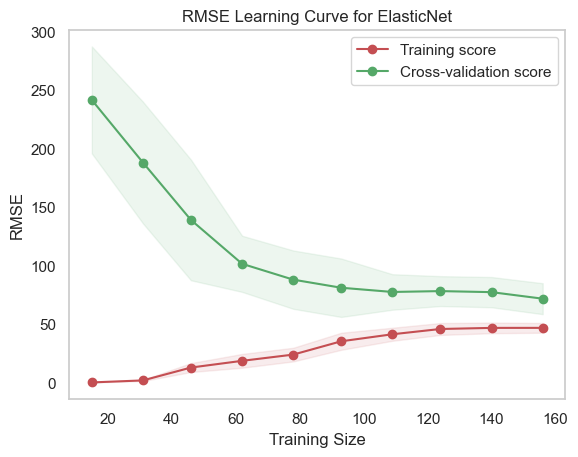

Rightmost Gap: 0.0747


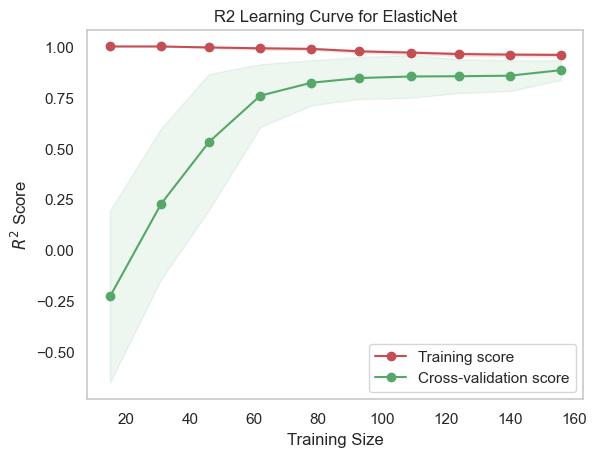

In [17]:
model=ElasticNet(random_state=RANDOM_STATE, alpha=0.0012648552168552957, l1_ratio=0.9, max_iter=1000, selection='random', tol=0.0001)
full_report(model,X_train_scaled,y_train,X_test_scaled,y_test,'ElasticNet',RANDOM_STATE,5,5)

In [18]:
from sklearn.utils import resample

n_iterations = 1000
r2_scores = []
rmse_scores = []

final_model=model

for i in range(n_iterations):
    X_sample, y_sample = resample(X_test_scaled, y_test, replace=True, random_state=42+i)
    y_pred = final_model.predict(X_sample)
    
    r2_scores.append(r2_score(y_sample, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_sample, y_pred)))

r2_mean = np.mean(r2_scores)
r2_ci = np.percentile(r2_scores, [2.5, 97.5])

rmse_mean = np.mean(rmse_scores)
rmse_ci = np.percentile(rmse_scores, [2.5, 97.5])

print(f"R²: {r2_mean:.3f}, 95% CI: [{r2_ci[0]:.3f}, {r2_ci[1]:.3f}]")
print(f"RMSE: {rmse_mean:.2f}, 95% CI: [{rmse_ci[0]:.2f}, {rmse_ci[1]:.2f}]")

R²: 0.941, 95% CI: [0.898, 0.968]
RMSE: 46.43, 95% CI: [37.68, 54.77]


In [3]:
#CHANGE: alpha=0.0003
model=ElasticNet(random_state=RANDOM_STATE, alpha=0.0003, l1_ratio=0.9, max_iter=1000, selection='random', tol=0.0001)
full_report(model,X_train_scaled,y_train,X_test_scaled,y_test,'ElasticNet',RANDOM_STATE,5,5)

NameError: name 'ElasticNet' is not defined

In [24]:
from sklearn.utils import resample

n_iterations = 1000
r2_scores = []
rmse_scores = []

final_model=model

for i in range(n_iterations):
    X_sample, y_sample = resample(X_test_scaled, y_test, replace=True, random_state=42+i)
    y_pred = final_model.predict(X_sample)
    
    r2_scores.append(r2_score(y_sample, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_sample, y_pred)))

r2_mean = np.mean(r2_scores)
r2_ci = np.percentile(r2_scores, [2.5, 97.5])

rmse_mean = np.mean(rmse_scores)
rmse_ci = np.percentile(rmse_scores, [2.5, 97.5])

print(f"R²: {r2_mean:.3f}, 95% CI: [{r2_ci[0]:.3f}, {r2_ci[1]:.3f}]")
print(f"RMSE: {rmse_mean:.2f}, 95% CI: [{rmse_ci[0]:.2f}, {rmse_ci[1]:.2f}]")

R²: 0.934, 95% CI: [0.888, 0.965]
RMSE: 48.95, 95% CI: [39.46, 58.04]


In [26]:
# ---------------------- Param Grid ----------------------
param_grid = {
    'alpha': [0.0003],         
    'l1_ratio': [0.9],   
    'max_iter': [1000],
    'tol': [1e-4],
    'selection': ['random']
}

# ---------------------- Repeated Nested CV + Filtering ----------------------
random_seeds = [42, 52, 62, 72, 82]
results = []

for seed in random_seeds:
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=seed)

    nested_r2_scores = []
    nested_mse_scores = []
    best_params_in_seed = []

    for train_idx, val_idx in outer_cv.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        grid = GridSearchCV(
            estimator=ElasticNet(random_state=seed),
            param_grid=param_grid,
            cv=inner_cv,
            scoring='r2',
            n_jobs=-1
        )

        grid.fit(X_tr, y_tr.values.ravel())
        best_model = grid.best_estimator_
        best_params_in_seed.append(grid.best_params_)

        y_pred_val = best_model.predict(X_val)
        nested_r2_scores.append(r2_score(y_val, y_pred_val))
        nested_mse_scores.append(mean_squared_error(y_val, y_pred_val))

    mean_r2 = np.mean(nested_r2_scores)
    std_r2 = np.std(nested_r2_scores)
    mean_rmse = np.sqrt(np.mean(nested_mse_scores))

    # ---------- FILTER ----------
    accepted = (mean_r2 - std_r2) >= 0.40

    best_index = np.argmax(nested_r2_scores)
    final_params = best_params_in_seed[best_index]

    final_model = ElasticNet(**final_params, random_state=seed)
    final_model.fit(X_train_scaled, y_train)

    y_pred_test = final_model.predict(X_test_scaled)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))


    results.append({
        'Seed': seed,
        'Mean_R2': mean_r2,
        'Std_R2': std_r2,
        'Accepted': accepted,
        'Test_R2': r2_test,
        'Test_RMSE': rmse_test,
        'Best_Hyperparams': final_params
    })

# ---------------------- Summary Table ----------------------
results_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)  

print("\nFiltered Model Summary Across Seeds:\n")
print(results_df)


Filtered Model Summary Across Seeds:

   Seed   Mean_R2    Std_R2  Accepted   Test_R2  Test_RMSE  \
0    42  0.905645  0.035323      True  0.938523  49.214032   
1    52  0.894401  0.015613      True  0.938487  49.228509   
2    62  0.900395  0.033781      True  0.938513  49.218302   
3    72  0.906522  0.029863      True  0.938500  49.223447   
4    82  0.908410  0.028021      True  0.938560  49.199164   

                                                                             Best_Hyperparams  
0  {'alpha': 0.0003, 'l1_ratio': 0.9, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}  
1  {'alpha': 0.0003, 'l1_ratio': 0.9, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}  
2  {'alpha': 0.0003, 'l1_ratio': 0.9, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}  
3  {'alpha': 0.0003, 'l1_ratio': 0.9, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}  
4  {'alpha': 0.0003, 'l1_ratio': 0.9, 'max_iter': 1000, 'selection': 'random', 'tol': 0.0001}  


In [25]:
print('Train Y Mean:',y_train.mean().values[0])
print('Train Y STD:',y_train.std().values[0])
print('Test Y Mean:',y_test.mean().values[0])
print('Test Y STD:',y_test.std().values[0])

Train Y Mean: 378.37948717948717
Train Y STD: 231.76463262948468
Test Y Mean: 351.2244897959184
Test Y STD: 200.54449478296607
